In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import model_selection

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Datos

In [3]:
path = '/home/maryskal/Downloads/Garbage classification'
path = '/home/mr1142/Documents/Data/Garabge'

In [4]:
classes = os.listdir(path)

In [5]:
directorios = []
clases = []
for clase in classes:
    dir_list = [os.path.join(path, clase, dir) for dir in os.listdir(os.path.join(path, clase))]
    directorios += dir_list
    clases += [clase for i in range(len(dir_list))]

In [6]:
df = pd.DataFrame()
df['directorios'] = directorios
df['clase'] = clases

In [7]:
df = pd.concat([df, pd.get_dummies(df.clase)], axis = 1)

In [8]:
df.head()

,directorios,clase,cardboard,glass,metal,paper,plastic,trash
0,/home/mr1142/Documents/Data/Garabge/glass/glas...,glass,0,1,0,0,0,0
1,/home/mr1142/Documents/Data/Garabge/glass/glas...,glass,0,1,0,0,0,0
2,/home/mr1142/Documents/Data/Garabge/glass/glas...,glass,0,1,0,0,0,0
3,/home/mr1142/Documents/Data/Garabge/glass/glas...,glass,0,1,0,0,0,0
4,/home/mr1142/Documents/Data/Garabge/glass/glas...,glass,0,1,0,0,0,0


In [9]:
df = df.sample(frac=1).reset_index(drop = True)
df.head()

,directorios,clase,cardboard,glass,metal,paper,plastic,trash
0,/home/mr1142/Documents/Data/Garabge/glass/glas...,glass,0,1,0,0,0,0
1,/home/mr1142/Documents/Data/Garabge/plastic/pl...,plastic,0,0,0,0,1,0
2,/home/mr1142/Documents/Data/Garabge/paper/pape...,paper,0,0,0,1,0,0
3,/home/mr1142/Documents/Data/Garabge/paper/pape...,paper,0,0,0,1,0,0
4,/home/mr1142/Documents/Data/Garabge/glass/glas...,glass,0,1,0,0,0,0


In [10]:
def charge_reshape(path):
    img = Image.open(path)
    img = img.resize((256,256))
    img = np.array(img)
    try:
        img = img[:,:,0]
    except:
        print('e')
    img = np.expand_dims(img, axis=-1)
    img = img/256
    return img

In [11]:
tensor = np.zeros((len(df),256,256,1))
for i in range(len(df)):
    tensor[i,...] = charge_reshape(df.directorios[i])

Como son 6 variables de salida hay que meter como output un array que tenga 6 valores.

In [12]:
X = tensor
Y = df[df.columns[2:8]].to_numpy()

In [13]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, 
                                                                    random_state=42, shuffle=True, stratify=Y )

In [14]:
len(Y_train)

2021

In [15]:
print(list(df.columns[2:]))
print(np.sum(Y_train, axis=0)/np.sum(Y_train)*100)
print(np.sum(Y_test, axis=0)/np.sum(Y_test)*100)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
[15.93270658 19.84166254 16.22958931 23.50321623 19.04997526  5.44285007]
[16.00790514 19.76284585 16.2055336  23.51778656 19.16996047  5.33596838]


## Modelo

Cogemos el modelo efficienNet con los pesos de imagenet

### EfficientNet

In [16]:
input_shape = (256,256,3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)

In [17]:
type(conv_base)

tensorflow.python.keras.engine.functional.Functional

In [18]:
len(conv_base.layers)

237

In [19]:
# conv_base.summary()

### Modelo

- Añado una capa inicial para poder entregarle el input de 3 canales. 
- Añado 1 convolución con max pooling y una segunda convolución cno globalMaxPooling para ajustar mejor
- Añado Dropout para evitar overfiting
- Añado la capa final con 6 neuronas de salida

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(3,3,padding="same", input_shape=(256,256,1), activation='elu', name = 'conv_inicial'))
model.add(conv_base)
model.add(layers.Conv2D(3,32, padding='same', input_shape=(8,8,1280), activation='selu', name = 'conv_posterior'))
model.add(layers.MaxPool2D(pool_size = (2,2), padding='same', name = 'first_pooling'))
model.add(layers.Conv2D(3,64, padding='same', input_shape=(4,4,1280), activation='selu', name = 'last_convolution'))
model.add(layers.GlobalMaxPooling2D(name="general_max_pooling"))
model.add(layers.Dropout(0.2, name="dropout_out"))
model.add(layers.Dense(len(np.unique(df.clase)), activation="softmax", name="fc_out"))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_inicial (Conv2D)        (None, 256, 256, 3)       30        
_________________________________________________________________
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
conv_posterior (Conv2D)      (None, 8, 8, 3)           3932163   
_________________________________________________________________
first_pooling (MaxPooling2D) (None, 4, 4, 3)           0         
_________________________________________________________________
last_convolution (Conv2D)    (None, 4, 4, 3)           36867     
_________________________________________________________________
general_max_pooling (GlobalM (None, 3)                 0         
_________________________________________________________________
dropout_out (Dropout)        (None, 3)                 0

### 1º entrenamiento
Solo vamos a entrenar las capas que hemos añadido

In [22]:
conv_base.trainable = False

In [23]:
len(model.trainable_variables)

8

Escogemos el optimizador Adam y funcion de coste CategoricalCrosentropy

In [24]:
lr = 0.01

In [25]:
opt = tf.keras.optimizers.Adam(learning_rate = lr)
loss = tf.keras.losses.CategoricalCrossentropy()

In [26]:
model.compile(optimizer=opt, loss = loss , metrics = ['CategoricalAccuracy', 'AUC'])

#### Entrenamiento

In [27]:
batch_size = 60
initial_epochs = 10

In [28]:
print('loss, acuracy, auc')
model.evaluate(X_test, Y_test)

loss, acuracy, auc
16/16 [==============================] - 81s 3s/step - loss: 1.7915 - categorical_accuracy: 0.1606 - auc: 0.5023


[1.7914429903030396, 0.1620553433895111, 0.5039525628089905]

In [29]:
history = model.fit(X_train,Y_train, batch_size = batch_size, epochs = initial_epochs, 
                    validation_data = (X_test, Y_test))

Epoch 1/10
34/34 [==============================] - 185s 3s/step - loss: 2.5483 - categorical_accuracy: 0.1499 - auc: 0.5302 - val_loss: 1.7371 - val_categorical_accuracy: 0.2352 - val_auc: 0.5984
Epoch 2/10
34/34 [==============================] - 16s 483ms/step - loss: 1.7452 - categorical_accuracy: 0.2053 - auc: 0.5834 - val_loss: 1.7405 - val_categorical_accuracy: 0.1621 - val_auc: 0.5474
Epoch 3/10
34/34 [==============================] - 17s 511ms/step - loss: 1.7392 - categorical_accuracy: 0.2222 - auc: 0.5904 - val_loss: 1.7256 - val_categorical_accuracy: 0.2352 - val_auc: 0.6047
Epoch 4/10
34/34 [==============================] - 17s 515ms/step - loss: 1.7425 - categorical_accuracy: 0.2281 - auc: 0.5922 - val_loss: 1.7277 - val_categorical_accuracy: 0.2352 - val_auc: 0.6049
Epoch 5/10
34/34 [==============================] - 17s 513ms/step - loss: 1.7324 - categorical_accuracy: 0.2321 - auc: 0.5946 - val_loss: 1.7261 - val_categorical_accuracy: 0.2352 - val_auc: 0.6051
Epoch 6

In [30]:
import re
len(history.history.keys())/2

3.0

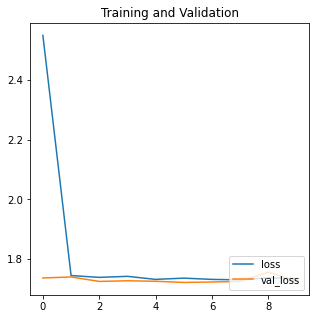

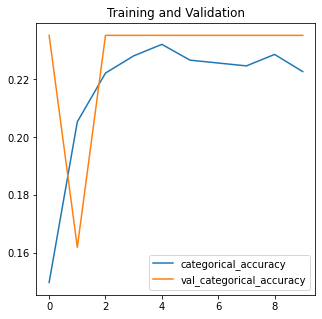

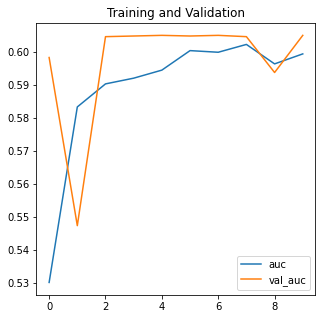

In [31]:
epochs_range = range(initial_epochs)
i = 0
for i in range(int(len(history.history.keys())/2)):
    key = list(history.history.keys())[i]
    
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 1, 1)
    plt.plot(epochs_range, history.history[key], label=key)
    plt.plot(epochs_range, history.history['val_' + key], label='val_' + key)
    plt.legend(loc='lower right')
    plt.title('Training and Validation')
plt.show()

### 2º Entrenamiento
Ahora vamos a entrenar tambien la red preentrenada, pero no queremos entrenar todas las capas, únicamente las capas más profundas, ya que las primeras capas son muy genéricas.

In [32]:
conv_base.trainable = True

In [33]:
len(conv_base.layers)

237

Vamos a entrenar desde la capa 100 en adelante

In [34]:
fine_tune_at = 100

for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable = False

In [35]:
len(model.trainable_variables)

131

Como el modelo es mucho más grande tenemos que usar un learning rate más bajo del que usabamos.
Vamos a utilizar dos learning rates, uno para el modelo preentrenado y otro para las capas nuevas

In [36]:
opt = [tf.keras.optimizers.Adam(learning_rate = lr), tf.keras.optimizers.RMSprop(learning_rate = lr/100)]
optimizers_and_layers = [(opt[0], model.layers[0]),
                         (opt[1], model.layers[1]),
                         (opt[0], model.layers[2:])]
opt = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

In [37]:
loss = tf.keras.losses.CategoricalCrossentropy()

In [38]:
model.compile(optimizer=opt, loss = loss , metrics = ['CategoricalAccuracy', 'AUC'])

#### Entrenamiento

In [39]:
batch_size = 60
fine_tune_epochs = 20
total_epoch = initial_epochs + fine_tune_epochs

In [ ]:
history = model.fit(X_train,Y_train, 
                    batch_size = batch_size,
                    epochs = total_epoch,
                    initial_epoch=history.epoch[-1],
                    validation_data = (X_test, Y_test))

Epoch 10/30
12/34 [=========>....................] - ETA: 10s - loss: 182.7858 - categorical_accuracy: 0.1392 - auc: 0.4883

In [ ]:
epochs_range = len(history.history['loss'])
i = 0
for i in range(int(len(history.history.keys())/2)):
    key = list(history.history.keys())[i]
    
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 1, 1)
    plt.plot(history.history[key], label=key)
    plt.plot(history.history['val_' + key], label='val_' + key)
    plt.legend(loc='lower right')
    plt.title('Training and Validation')
plt.show()